## 0. Modules and Custom Functions

In [1]:
from matplotlib.pyplot import style, rcParams, subplots
from pandas import read_csv, Categorical

In [15]:
style.use("ggplot")
ggcolors = rcParams['axes.prop_cycle'].by_key()['color']
rcParams["figure.figsize"] = (12, 8)

In [3]:
def get_features(df):
    
    numerical, categorical, dates, other = [], [], [], []
    
    columns = df.columns.tolist()
    for c in columns:
        if df[c].dtype in ["int64", "float64"]:
            numerical.append(c)
        elif df[c].dtype == "object":
            categorical.append(c)
        elif df[c].dtype == "datetime64[ns]":
            dates.append(c)
        else:
            other.append(c)
                
    return numerical, categorical, dates, other

In [92]:
def get_title(df):
    lastname_removed = df["name"].str.split(",").apply(lambda x: x[1])
    title = lastname_removed.str.split(".").apply(lambda x: x[0])
    clean_title = title.str.lower().str.strip()
    cat = clean_title.apply(lambda t: "other" if t not in ["mr", "mrs", "ms", "miss"] else t)
    return cat

## 1. Get Data

In [4]:
data = read_csv("../data/raw/train.csv")
data = data.rename(columns=dict(zip(data.columns, data.columns.str.lower())))
data = data.set_index("passengerid")

In [5]:
data.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Data Transformation

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [144]:
df_interim = data.copy()

In [145]:
df_interim = df_interim.rename(columns={"survived": "target"})

In [146]:
def get_women_marital_status(gender, title):
    if (gender == "female") and (title in ["mrs", "ms"]):
        marital_status = True
    elif gender == "male":
        marital_status = None
    else:
        marital_status = False
    return marital_status

In [147]:
df_interim["pclass"] = Categorical(df_interim["pclass"].map({3:"low", 2:"mid", 1:"high"}), categories=["low", "mid", "high"], ordered=True)
df_interim["title"] = get_title(df_interim)
df_interim["women_marital_status"] = df_interim.apply(lambda x: get_women_marital_status(x["sex"], x["title"]), axis=1)

## 3. Exploratory Data Analysis

In [148]:
df_interim.isna().sum().sort_values(ascending=False) / len(df_interim)

cabin                   0.771044
women_marital_status    0.647587
age                     0.198653
embarked                0.002245
target                  0.000000
pclass                  0.000000
name                    0.000000
sex                     0.000000
sibsp                   0.000000
parch                   0.000000
ticket                  0.000000
fare                    0.000000
title                   0.000000
dtype: float64

In [157]:
def plot_perc_from_total(kind, df, column, title, color, dropna, sort_index, ax=None):
    sort_index = sort_index or False
    dropna = dropna or False
    
    counts = df[column].value_counts(normalize=True, dropna=dropna)
    if sort_index:
        counts = counts.sort_index(ascending=True)
    if ax is not None:
        counts.plot(kind=kind, title=title, color=color, ax=ax)
        for label in ax.get_xticklabels():
            label.set_rotation(0)
    
    return counts

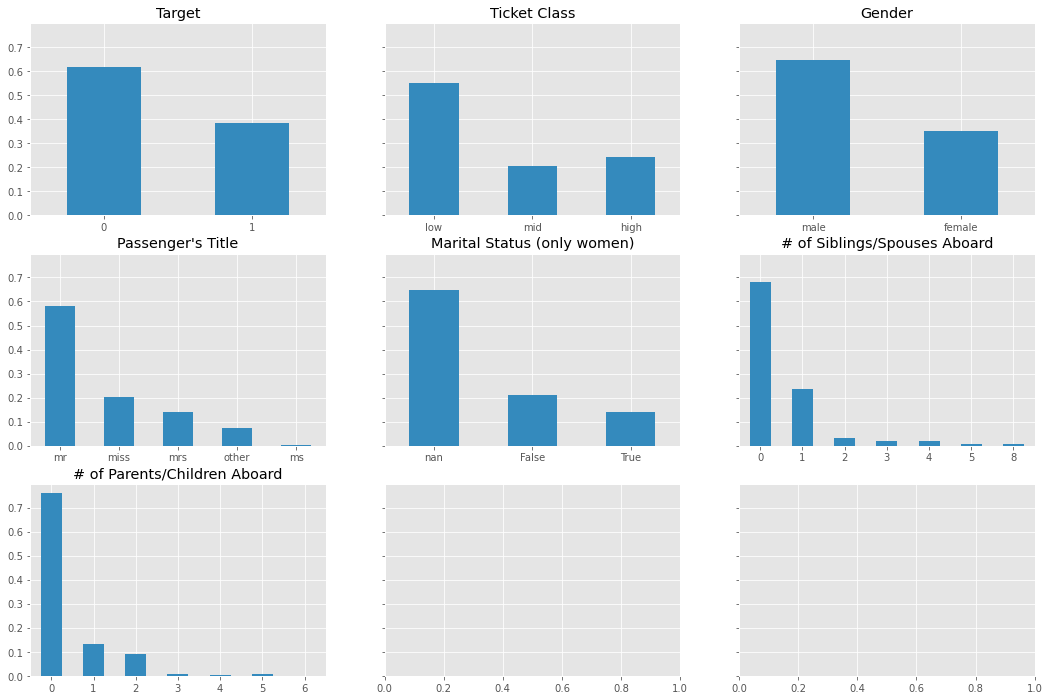

In [158]:
fig, axs = subplots(3, 3, figsize=(18, 12), sharey=True)

target_counts = plot_perc_from_total("bar", df_interim, "target", "Target", ggcolors[1], False, False, axs[0, 0])
tck_class_counts = plot_perc_from_total("bar", df_interim, "pclass", "Ticket Class", ggcolors[1], False, True, axs[0, 1])
sex_counts = plot_perc_from_total("bar", df_interim, "sex", "Gender", ggcolors[1], False, False, axs[0, 2])
title_counts = plot_perc_from_total("bar", df_interim, "title", "Passenger's Title", ggcolors[1], False, False, axs[1, 0])
wms_counts = plot_perc_from_total("bar", df_interim, "women_marital_status", "Marital Status (only women)", ggcolors[1], False, False, axs[1, 1])
sibsp_counts = plot_perc_from_total("bar", df_interim, "sibsp", "# of Siblings/Spouses Aboard", ggcolors[1], False, True, axs[1, 2])
parch_counts = plot_perc_from_total("bar", df_interim, "parch", "# of Parents/Children Aboard", ggcolors[1], False, True, axs[2, 0])

In [164]:
numerical, categorical, dates, other = get_features(df_interim.drop("target", axis=1, inplace=False))